In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from tqdm.auto import tqdm

/mnt/d/University/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.Dataset and Dataloader

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


# 2.Checking that the transforms are correct

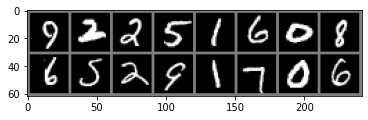

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# # show images
imshow(torchvision.utils.make_grid(images))
# # print labels

# 3.Implement Model

In [4]:
from vit_pytorch import ViT

model = ViT(
    image_size = 28,
    patch_size = 7,
    num_classes = 10,
    dim = 64,
    depth = 3,
    heads = 4,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 28, 28)

preds = model(img) # (1, 1000)
preds

tensor([[-0.2226,  0.0367, -0.2404, -0.7191,  0.4395, -0.6126, -0.2331, -0.1203,
          0.3415,  0.7146]], grad_fn=<AddmmBackward0>)

# 4.Implement Optimizer and Loss

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# 5.Training Loops

In [6]:
from email.mime import image
for epoch in range(1):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0


 27%|██▋       | 1005/3750 [00:25<01:03, 43.14it/s]

[1,  1000] loss: 1.192


 53%|█████▎    | 2002/3750 [00:57<03:25,  8.49it/s]

[1,  2000] loss: 0.482


 80%|████████  | 3006/3750 [01:29<00:19, 39.05it/s]

[1,  3000] loss: 0.376


100%|██████████| 3750/3750 [01:52<00:00, 33.32it/s]


# 6.Test 

In [7]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(trainloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


100%|██████████| 3750/3750 [00:43<00:00, 85.75it/s] 

Accuracy of the network on the 10000 test images: 90 %
